<span style="color:#A00;font-weight:bold">Missing data: this notebook relies on calibration FITS files from Nickel. The files are not provided.</span>

## Photometric analysis

*Mean of means (MOM), standard deviation of means (SDOM), estimation of signal noise, CCD gain, linear regression*

Photometry is a branch of observational astronomy that deals with measuring the brightness of celestial objects. Measurements are usually carried out in two steps:

* First, the brightness is computed as "seen" by the telescope system. I.e., the quantities of interest are the number of ADUs the object produces per unit time and the noise (uncertainty) in that. Of course, same numbers of ADUs will correspond to different absolute brightness depending on the telescope system used and the transmissivity of the atmosphere at the observation site. A larger telescope in the mountains will register more ADUs per second from the same source than a smaller telescope in a dusty area at sea level. Hence, the second step.
* Second, the instrumental brightness is compared against that of reference objects to express the value in terms of some absolute instrument-independent scale. A commonly used scale in astronomy is the apparent magnitude scale based on the brightness of the star Vega.

In this experiment, we temporarily ignore the second step and focus entirely on the first. Furthermore, instead of measuring the brightness of a celestial object, we will be using flat fields to measure the brightness of the inside of the telescope dome. This notebook will address two specific challenges:

* Calculating the uncertainty in a photometric measurement derived from a single frame. I.e., estimating the amount of noise present in the frame.
* Extracting combined photometric measurements and their uncertainties from multiple frames of the same object (in this case, multiple flat fields).

We start by importing the usual set of modules. The only new addition is a routine called `gaussian_filter` from the scientific computing library **SciPy**. We will need this routine later in this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os
from scipy.ndimage.filters import gaussian_filter

%matplotlib inline

## Noise extraction

Suppose, we are presented with a flat field. The average brightness of the frame will be simply the average count in ADUs divided by the exposure time. But how do we estimate the noise (uncertainty) in that? Naively, one may be tempted to take the standard deviation over the entire frame (again, divided by the exposure time). Unfortunately, this would only work if the photon noise were **the only** contributor to the variation in signal. In reality, the CCD will be non-uniformly lit and obscured by dust particles and ice crystals, each often contributing more to the standard deviation of the frame than the noise itself.

The number of ADUs recorded at a pixel is proportional to the number of photoelectrons trapped, where the coefficient of proportionality is known as the **CCD gain** ($g$). The number of photoelectrons is expected to obey the Poisson probability distribution, implying that the variance and the mean of the distribution are equal. Therefore, the noise in the signal ($\sigma$) can be expressed in terms of the gain ($g$) and the mean count ($\mu$) as follows:

$$\sigma = \sqrt{\frac{\mu}{g}}$$

Here, both $\sigma$ and $\mu$ are expressed in ADUs.

I will now attempt to measure the noise level in every flat field to check how closely the real relationship between signal and noise matches the above theoretical prediction. For now, I will stick to the naive approach and merely take the standard deviation of the frame as my noise estimate.

First, we will need some functions:

In [2]:
# remove_outliers() is borrowed from the previous computing session
def remove_outliers(data, sigmas):
    """ Remove all values from the flattened array, data, that are too far from the mean """
    mean = np.mean(data)
    std = np.std(data)
    condition = np.logical_or(data < mean - sigmas * std, data > mean + sigmas * std)
    while (len(data[condition]) > 0):
        data = data[np.logical_not(condition)]
        mean = np.mean(data); std = np.std(data)
        condition = np.logical_or(data < mean - sigmas * std, data > mean + sigmas * std)
    return data

def read_exposure(filename):
    """ Read exposure time from a FITS file. Relies on external variable data_dir"""
    h = fits.open(data_dir + filename)
    exposure = float(h[0].header['EXPTIME'])
    h.close()
    return exposure

def read_data(filename):
    """ Read data from a FITS file. Relies on external variable data_dir"""
    h = fits.open(data_dir + filename)
    data = h[0].data * 1.0
    h.close()
    return data

def read_mean(filename):
    """ Obtain the mean value from a FITS file. Relies on external variable data_dir"""
    return np.mean(read_data(filename))

We will need to know the exposure times and the mean values for every frame. We will also need the average bias frame (master bias).
<br><br>
<div class="alert alert-warning">
<b>Python 3.x users</b>: This notebook uses the <code>map()</code> function. In Python 3.x, instead of a list of results, it returns a special iterable object. This may cause errors further down the line, as the map object does not support the entire range of sequence operations. You may want to typecast the output of <code>map()</code> into a list with <code>list()</code>.
</div>

In [3]:
data_dir = '../../FITS/data-2019-01-11/'          # Change this to YOUR data directory
data_files = np.array(os.listdir(data_dir))

# map() takes a function as an argument and applies it to every item in an array or a list. It
# returns the result of every application in a list. For example, "map(read_exposure, data_files)"
# means "apply read_exposure() to every item of data_files". This is another way to loop through data.


exposures = np.array(map(read_exposure, data_files))        # Retrieve ALL exposure times
means = np.array(map(read_mean, data_files))                # Retrieve ALL mean counts

all_biases = map(read_data, data_files[exposures == 0.0])   # Retrieve all bias frames (exposure = 0)
master_bias = np.sum(all_biases, axis = 0) / len(all_biases)

means -= np.mean(master_bias)                               # Correct all means for bias

Now, we define a function that takes a flat field and measures its noise by simply taking the standard deviation of the data:

In [4]:
def plain_std(filename):
    data = read_data(filename) - master_bias
    return np.std(data)

Let us try running this function on every flat and plotting the result alongside the theoretical prediction:

$$\sigma = \sqrt{\frac{\mu}{g}}$$

I will use logarithmic axes for visual clarity.

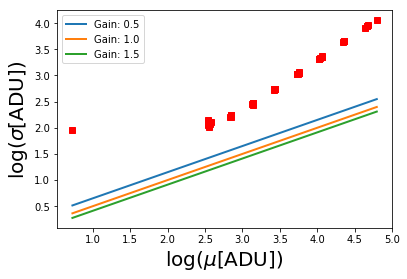

In [5]:
def plot_my_noise(means, noises):
    """ Plot measured mean values and estimated noise with theoretical prediction using Poisson. """
    log10_means = np.log10(means); log10_noises = np.log10(noises)
    plt.plot(log10_means, log10_noises, 'rs')  # Plot the measured values
    
    # Plot theoretical predictions for a range of different gains
    gains = np.linspace(0.5, 1.5, 3)
    for gain in gains:
        theoretical_means = np.linspace(min(log10_means), max(log10_means), 1000)
        theoretical_noises = 0.5 * theoretical_means - 0.5 * np.log10(gain)
        plt.plot(theoretical_means, theoretical_noises, '-', lw = 2, label = 'Gain: {value}'.format(value = gain))
    plt.legend(loc = "best")
        
    plt.xlabel("$\log(\mu \mathrm{[ADU]})$", size = 20) # This is a LaTeX equation. Do not worry
                                                        # if you are not familiar with this language.
    plt.ylabel("$\log(\sigma \mathrm{[ADU]})$", size = 20)

noises = map(plain_std, data_files[exposures != 0.0])
plot_my_noise(means[exposures != 0.0], noises)

As can be seen, our experimental results are drastically overestimated. This is expected, as plain standard deviation will capture all the non-uniformities in the flat fields in addition to the photon noise.

It has been previously suggested that instead of computing $\sigma$ across the entire frame, one can do so in a small subframe, thereby suppressing most of the unwanted variation. This approach suffers from a range of disadvantages:

* By taking a subframe, we are rejecting most of the data. This bounds our final estimate to be less precise.
* It is possible that a dust grain shadow or some other defect finds its way into the chosen subframe and skews the measurement. It is impractical to check every frame for this issue manually.
* It is not clear how big or how small the subframe should be to suppress all the unwanted variation and, yet, avoid undersampling the data.

Let us create a new function to sample the noise by taking a small (25x25 pixels) subframe and produce another plot of standard deviation VS mean to see if this method performs any better than plain standard deviation:

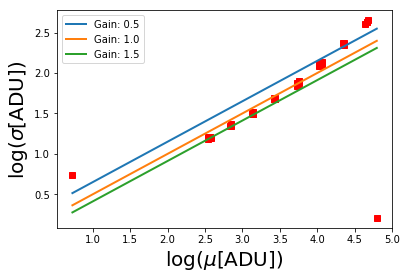

In [6]:
def subframe_std(filename):
    data = read_data(filename) - master_bias
    subframe = data[525:550, 525:550]
    subframe_without_outliers = remove_outliers(subframe.flatten(), 3)
    return np.std(subframe)

noises = map(subframe_std, data_files[exposures != 0.0])
plot_my_noise(means[exposures != 0.0], noises)

Hopefully, the new plot shows the data much closer to the prediction. Yet, it is likely that the data departs from the theoretical prediction at long exposures, where the unwanted non-uniformities become significant enough to invade the subframe.

An even better way to estimate the noise in a flat field would be by loading two different frames instead of one and finding the difference between them. If both flats were obtained using the same telescope and the same exposure time, the only difference between the two should be the noise, which is what we are trying to estimate.

A caveat one must keep in mind: the difference between the two flats will contain noise from both of them, while we are interested in just one of them. Assuming that the noise level in both is the same, one can obtain it by dividing the combined noise by $\sqrt{2}$:

C:\Users\Roman\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


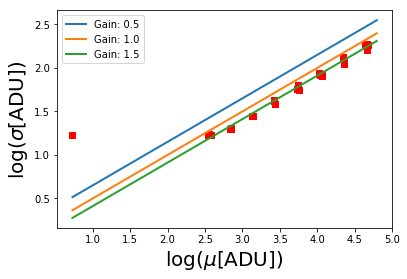

In [7]:
def double_flat(filename):
    exposure = exposures[data_files == filename]        # Get the exposure of the flat of interest
    
    # Find a different flat field with the same exposure
    another_flat = data_files[(exposure == exposures) & (data_files != filename)]
    
    # If not found, return 0 and exit. Nothing we can do here.
    if len(another_flat) == 0:
        return 0.0 # 0.0 will throw a warning when we compute its log() and will not be displayed on the plot.
    
    # Read in both flats
    flat1_data = read_data(filename)
    flat2_data = read_data(another_flat[0])
    
    # Find the difference
    diff = flat1_data - flat2_data
    
    # Clear the data of outliers and divide by sqrt(2) to get the noise in just one flat
    return np.sqrt(np.std(remove_outliers(diff, 3)) ** 2.0) / np.sqrt(2)

noises = map(double_flat, data_files[exposures != 0.0])
plot_my_noise(means[exposures != 0.0], noises)

Hopefully, the plot above demonstrates the superior accuracy of this method. It may also be possible to determine the gain of the camera by looking at the plot. The obvious disadvantage of the double-flat approach is the need for two flat fields, which may not always be satisfied.

To close off, I propose a fourth way of estimating the noise level with only one flat field available. We will blur the flat using a routine called *gaussian_filter* from **SciPy**. With some luck, the blur will not remove large-scale defects, such as dust grain shadows and the overall brightness gradient. It will, however, remove small-scale effects, which is what photon noise is expected to be. By dividing the original image by the blurred one and renormalizing it, we can obtain an image that contains the photon noise only. Let's give it a try:

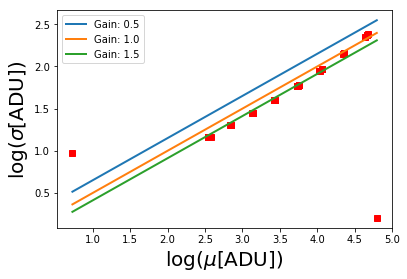

In [8]:
def gaussian_blur(filename):
    data = read_data(filename) - master_bias
    blur = gaussian_filter(data, 2.0)     # Apply blur
    synthetic_flat = remove_outliers(data / blur * np.mean(blur), 3)
    return np.std(synthetic_flat)

noises = map(gaussian_blur, data_files[exposures != 0.0])
plot_my_noise(means[exposures != 0.0], noises)

The plots above should help you determine which method is more appropriate and give an approximate estimate of the CCD gain used in this experiment.

## Data stacking

Now onto the second challenge. Suppose, multiple images of the same object were taken during an observing session. Also suppose that their means and noise levels were calculated using one of the techniques above as $\mu_1$, $\mu_2$, $\mu_3$... and $\sigma_1$, $\sigma_2$, $\sigma_3$...

The images, in general, will have different exposure times: $t_1$, $t_2$, $t_3$ etc.

The challenge is to obtain a single estimate of the mean count per unit time, $\mu/t$ and a single estimate of its uncertainty, $\sigma/t$ using all the available data. In other words, we need to compute the **mean of means** (MOM) and the **standard deviation of means** (SDOM).

Importantly, MOM is **not** a simple average of $\mu_1/t_1$, $\mu_2/t_2$, $\mu_3/t_3$... This is because frames of shorter exposure are expected to yield less precise mean counts and, hence, should have less influence on the MOM. This is not accounted for in the regular arithmetic mean formula, where every data point is treated equally. Instead, an alternative equation below can be used to satisfy this requirement:

$$\textrm{MOM}=\frac{\textrm{Total count}}{\textrm{Total exposure}}=\frac{\mu_1 + \mu_2 + \mu_3 + ...}{t_1 + t_2 + t_3 + ...}$$

Since frames of longer exposure produce higher counts, they will be making a more significant contribution to the MOM than frames of shorter exposure and, consequently, lower counts.

SDOM is the uncertainty in MOM. We can derive it using the standard uncertainty propagation formula:

$$\textrm{SDOM}=\frac{\sqrt{\sigma_1^2 + \sigma_2^2 + \sigma_3^2 + ...}}{t_1 + t_2 + t_3 + ...}$$

The cell below attempts to use the given formulae to compute the MOM and SDOM of the entire dataset:

<div class="alert alert-warning">
<b>Note</b>: The cell below does not check for outliers (e.g. saturated frames). It is left up to the students to introduce appropriate conditions to skip bad frames. Saturated frames are given away by their maximum count exceeding 60 000 ADU (roughly, the upper limit of the linear response in a typical CCD).
<br><br>
Since every flat in the dataset was taken under similar conditions, their brightness ($\mu/t$) should be approximately the same. Any significant deviation from the average brightness across all frames will also be indicative of a potential candidate to exclude.
</div>

In [9]:
exposures = np.array(map(read_exposure, data_files))        # Retrieve ALL exposure times
means = np.array(map(read_mean, data_files))                # Retrieve ALL mean counts

all_biases = map(read_data, data_files[exposures == 0.0])   # Retrieve all bias frames (exposure = 0)
master_bias = np.sum(all_biases, axis = 0) / len(all_biases)

means -= np.mean(master_bias)                               # Correct all means for bias

noises = np.array(map(gaussian_blur, data_files))           # Use the blur method to obtain sigmas

# Remove all bias frames
means  = means[exposures != 0.0]
noises = noises[exposures != 0.0]
exposures = exposures[exposures != 0.0]

print "MOM:", np.sum(means)  / np.sum(exposures), "ADU / s"
print "SDOM:", np.sum(np.sqrt(noises ** 2.0))  / np.sum(exposures), "ADU /s"


print np.sqrt(np.sum((((means / exposures) - np.sum(means)  / np.sum(exposures))) ** 2.0) / len(means))

MOM: 110.90128087796528 ADU / s
SDOM: 0.723469167229252 ADU /s
17.989535158847808


In [10]:
print np.sqrt(np.mean((means - np.sum(means)  / np.sum(exposures)) ** 2.0))
print means - np.sum(means)  / np.sum(exposures)

18167.75946926161
[ -105.54345971   238.79879771   240.21878709   247.63522811
   585.36954948   574.91164339   588.1560374   1279.19187151
  1282.26365533  1288.41119302  2655.18740022  2657.25919236
  2659.33160503  5572.49194161  5590.55048172  5578.61117656
 11401.99589317 11500.81829844 11570.05891845 22789.1998403
 22685.13442633 22531.20137728 45552.73861704 42739.72339617
 62384.82847559 47871.33846594 45821.22714891 22250.17845395
 10468.85161069 10458.36732724 10737.70639788  5286.57360572
  5302.86034334  5341.85847807  2573.69298772  2545.7402502
  2574.28487059  1245.02718201  1262.46131676  1280.467731
   602.8430482    601.14489849   587.28706971   255.08881088
   258.91877155   267.56918252]


## Linear regression

**Model fitting** is one of the most commonly encountered problems in scientific computing. Often, we can use physical intuition to predict the mathematical relationship a dataset should obey. For example:

* The mean count in a frame should scale linearly with exposure.
* The average of a randomly drawn sample should tend towards the Gaussian probability distribution.
* A body moving through a fluid should experience drag as a power law of its velocity.

Very often, these mathematical relationships (**models**) will have free parameters that we do not a priori know. For example, we may not know the slope of the linear model, the standard deviation of the Gaussian model or the index of the drag power law.

The aim of model fitting is finding values for those parameters that are most likely to be correct, should our choice of the model genuinely match the distribution of the data.

In this experiment, you may use model fitting to determine the gain of the system. Recall the equation:

$$\sigma = \sqrt{\frac{\mu}{g}}$$

This equation is our model and $g$ is its free parameter to be determined. We can simplify the model by converting standard deviations into variances. Square both sides of the equation:

$$\textrm{Var} = \frac{\mu}{g}$$

Now, the model is a first-order polynomial. This model is so common that the process of its application has a special name: **linear regression**. The code snippet below attempts to use linear regression to calculate the gain of the CCD.

In [11]:
# np.polyfit() fits a polynomial model to the data. The third parameter sets the degree.
# "1" results in linear regression. cov=True means "obtain the covariance matrix as well".
coefficients, cov_matrix = np.polyfit(noises ** 2.0, means, 1, cov = True)


# The first returned value (coefficients) stores the coefficients of the polynomial in the order
# of decreasing power (i.e., slope comes first, then y-offset)
print "Slope:", coefficients[0]
print "Y-offset:", coefficients[1]

# The second value (cov_matrix) is the so called "covariance matrix". For linear regression, it is
# a 2x2 matrix, where the [0,0] element contains the variance of the slope, [1,1] contains the variance
# of the y-offset and both [0,1] and [1,0] contain their mutual covariance
print "Error in slope:", np.sqrt(cov_matrix[0,0])
print "Error in y-offset:", np.sqrt(cov_matrix[1,1])
print "Covariance:", cov_matrix[1,0]

# Finally, the gain is the inverse of the slope:
print "Gain:", 1.0 / coefficients[0], 'photoelectrons per ADU'

# What is the error in gain? ...
# Should probably overplot the data and the model to inspect the fit visually...

Slope: 0.7748604987565996
Y-offset: 3512.280173244027
Error in slope: 0.08673350061567095
Error in y-offset: 1550.4450538626986
Covariance: -64.4174304730292
Gain: 1.2905548825945787 photoelectrons per ADU
